In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import scipy.stats
from pybedtools import BedTool
import pickle
from tqdm import tqdm
from pyfaidx import Fasta

from seq2atac.stable import compute_gc_bed, one_hot_encode, read_pickle, compute_signal, write_pickle
from seq2atac.analysis import get_promoterai_tss, get_cosmic_pancan_genes, fasta_file
from seq2atac.analysis.enrichment_utils import create_pancancer_distribution_plots, create_pancancer_correlations, create_pancancer_valuecounts, create_pancancer_distribution_plots_discrete
from seq2atac.analysis.sample_controls import matching_logic
from seq2atac.analysis.mutation_utils import compute_vierstra_groups, compute_trinuc, ingene_indicator
from seq2atac.analysis.mutation_processing_pipeline_utils import annotateNearestGene, annotateScore, filterannotatePeaks, annotatePhylopScore, annotatePhylopScorePeak, annotateBedfile

/home/akumar22/anaconda3/envs/python38/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_tcga_cancers = ["BLCA","BRCA","GBM","COAD","KIRC","KIRP","LUAD"]

In [3]:
### Expt 1 - baseline enrichment - needs to be thought about

In [4]:
pancan_genes = read_pickle("../process_tcga_icgc/ogtsg.pkl")
len(pancan_genes)

565

In [5]:
#### 
somatic_df_dict = {}
for cancer_name in all_tcga_cancers:
    print(cancer_name)
    somatic_df = read_pickle(f"../somatic_filtered/{cancer_name}_filtered_annotated_somatic.pkl")
    print(somatic_df.shape)
    
    ### closest pancan annotation
    somatic_df["closest_pancan"] = somatic_df["gene"].apply(lambda x : ingene_indicator(x, pancan_genes))
    
    ### inside peaks or not
    somatic_df = annotateBedfile(somatic_df,
                               f"/illumina/scratch/deep_learning/akumar22/TCGA/mutations_scoring/master_files/cancer_peaks_500/{cancer_name}_peaks_indexed.bed",
                               "inside_peaks")
    print(somatic_df.shape)
    

    gof_selector = []
    for idx,row in somatic_df.iterrows():
        if (row["inside_peaks"]==0) and (row["distance_to_summit"] <= 1000):
            gof_selector.append(1)
        else:
            gof_selector.append(0)
    somatic_df["gof_selector"] = gof_selector
    
    
    assert len(somatic_df.drop_duplicates(["Chromosome","hg38_start","Tumor_Seq_Allele2"])) == len(somatic_df)
    
    somatic_df_dict[cancer_name] = somatic_df
    
    

BLCA
(155700, 31)
(155700, 32)
BRCA
(376478, 31)
(376478, 32)
GBM
(89159, 31)
(89159, 32)
COAD
(1165711, 31)
(1165711, 32)
KIRC
(223811, 31)
(223811, 32)
KIRP
(56691, 31)
(56691, 32)
LUAD
(377986, 31)
(377986, 32)


In [6]:
total_fisher = np.zeros((2,2))
for cancer_name in all_tcga_cancers:
    print(cancer_name)
    df = somatic_df_dict[cancer_name].copy()
    
    l1 = df[(df["closest_pancan"]==1) & (df["gof_selector"] == 1) ]
    l2 = df[(df["closest_pancan"]==1) & (df["gof_selector"] == 0)]
    l3 = df[(df["closest_pancan"]==0) & (df["gof_selector"] == 1)]
    l4 = df[(df["closest_pancan"]==0) & (df["gof_selector"] == 0)]


    fisher_matrix = np.array([[len(l1),len(l2)],[len(l3),len(l4)]])
    
    assert fisher_matrix.sum() == len(df)
    total_fisher += fisher_matrix
    fold_change,pval = scipy.stats.fisher_exact(fisher_matrix)
    print(fisher_matrix,fold_change,pval)
    
print("total")
print(total_fisher)
print(scipy.stats.fisher_exact(total_fisher))


BLCA
[[  1129   7843]
 [ 17309 129419]] 1.0763110246219707 0.026302426558549755
BRCA
[[  3528  17467]
 [ 52117 303366]] 1.1757033425632373 6.33111852335025e-17
GBM
[[  486  4210]
 [ 7884 76579]] 1.1212881918458986 0.022123719797292354
COAD
[[   4959   60651]
 [  79686 1020415]] 1.0470102888665136 0.002660158793536191
KIRC
[[   729  12040]
 [ 11560 199482]] 1.0448330967133777 0.2626531173038378
KIRP
[[  332  2816]
 [ 5255 48288]] 1.083357841017213 0.18577591025188595
LUAD
[[  1807  19033]
 [ 28980 328166]] 1.0750931811179574 0.004696578251673198
total
[[  12970.  124060.]
 [ 202791. 2105715.]]
(1.0855732002449745, 1.2907063923568016e-17)


### Expt2

In [3]:
ism_thresh = read_pickle("../process_tcga_icgc/ism_thresh_percentile.pkl")[99]
ism_thresh

{'brca': 0.34552914537146884,
 'blca': 0.393249265576302,
 'coad': 0.3665412973954391,
 'luad': 0.527243441255984,
 'kirp': 0.4390704091109736,
 'kirc': 0.44200819215624415,
 'gbm': 0.3969854090822131,
 'skcm': 0.39269212112721724}

In [8]:
somatic_df_dict = read_pickle("somatic_df_dict_gof.pkl")

In [9]:
def get_enrichments(somatic_df_dict, pancan_matched_dict, nonpancan_matched_dict, ism_thresh):
    q_to_or = {}
    q_to_pval = {}
    q_to_fisher = {}
    
    all_tcga_cancers = list(somatic_df_dict.keys())

    for q in [round(x,2) for x in np.linspace(0.5, 0.01, 50)] + [0.025]:
        print(q)

        total_fisher = np.zeros((2,2))

        for cancer_name in all_tcga_cancers:

            if cancer_name in ["SKCM"]:
                continue

            somatic_df = somatic_df_dict[cancer_name].copy()


            threshold = somatic_df["diff_mutation_centered"].quantile(q)
            ism_es = None
            if ism_thresh:
                ism_es = ism_thresh[cancer_name.lower()]

            pancan_df = pancan_matched_dict[cancer_name].copy()
            nonpancan_df = nonpancan_matched_dict[cancer_name].copy()
            
            l1 = None
            if ism_thresh:
                l1 = pancan_df[(pancan_df["diff_mutation_centered"]<threshold) & (pancan_df["mut"] > ism_es) & (pancan_df["ref-mut"] < 0)]
            else:
                l1 = pancan_df[(pancan_df["diff_mutation_centered"]<threshold)]
                
            l2 = pancan_df[~pancan_df.index.isin(l1.index)]
            
            l3 = None
            if ism_thresh:
                l3 = nonpancan_df[(nonpancan_df["diff_mutation_centered"]<threshold) & (nonpancan_df["mut"] > ism_es) & (nonpancan_df["ref-mut"] < 0)]
            else:
                l3 = nonpancan_df[(nonpancan_df["diff_mutation_centered"]<threshold)]
                
            l4 = nonpancan_df[~nonpancan_df.index.isin(l3.index)]

            fisher_matrix = np.array([[len(l1),len(l2)],[len(l3),len(l4)]])

            assert fisher_matrix.sum() == len(pancan_df) + len(nonpancan_df)
            total_fisher += fisher_matrix
            fold_change,pval = scipy.stats.fisher_exact(fisher_matrix)

        print(total_fisher)
        fold_change,pval = scipy.stats.fisher_exact(total_fisher)
        print(fold_change, pval)
        q_to_or[q] = fold_change
        q_to_pval[q] = -np.log10(pval)
        q_to_fisher[q] = total_fisher

    return q_to_fisher, q_to_or, q_to_pval

def plot_percentiles(q_to_or, q_to_pval, ymin=None, ymax=None, title=None, outfile=None):
    
        
    fig,axes = plt.subplots(1,2,figsize=(10,5))
    ax1,ax2 = axes
    ax1.scatter(q_to_or.keys(),q_to_or.values(), color="#ff7f0e")
    ax1.set_xlabel("threshold percentile of somatic")
    ax1.set_ylabel("fold change")
    ax1.axhline(1.0,color="#ff7f0e")
    ax1.set_ylim(bottom=ymin,top=ymax)
        
    
    ax2.scatter(q_to_pval.keys(),q_to_pval.values(), color="#ff7f0e")
    ax2.set_xlabel("threshold percentile of somatic")
    ax2.set_ylabel("-log10 p value")
    ax2.axhline(-np.log10(0.05),color="#ff7f0e")

    if title:
        fig.suptitle(title)
    fig.tight_layout()
    if outfile:
        fig.savefig(outfile,dpi=1200)
    else:
        plt.show()

### near og.tsg - with ism

In [10]:
pancan_matched_dict = read_pickle("pancan_matched_dict_ogtsg.pkl")
nonpancan_matched_dict = read_pickle("nonpancan_matched_dict_ogtsg.pkl")

0.5
[[ 128. 6984.]
 [ 122. 6990.]]
1.0500816855388428 0.7497635638893173
0.49
[[ 126. 6986.]
 [ 122. 6990.]]
1.0333782318735831 0.8476462258344882
0.48
[[ 124. 6988.]
 [ 119. 6993.]]
1.0427623825718038 0.7958359046113543
0.47
[[ 124. 6988.]
 [ 118. 6994.]]
1.0517497307733354 0.7458740257719463
0.46
[[ 124. 6988.]
 [ 118. 6994.]]
1.0517497307733354 0.7458740257719463
0.45
[[ 123. 6989.]
 [ 118. 6994.]]
1.043118605265902 0.795024149403047
0.44
[[ 123. 6989.]
 [ 118. 6994.]]
1.043118605265902 0.795024149403047
0.43
[[ 123. 6989.]
 [ 118. 6994.]]
1.043118605265902 0.795024149403047
0.42
[[ 122. 6990.]
 [ 118. 6994.]]
1.0344899493222763 0.8452047512018473
0.41
[[ 122. 6990.]
 [ 117. 6995.]]
1.0434809190173997 0.7942023948144444
0.4
[[ 121. 6991.]
 [ 116. 6996.]]
1.0438494813528725 0.7933704349800142
0.39
[[ 121. 6991.]
 [ 116. 6996.]]
1.0438494813528725 0.7933704349800142
0.38
[[ 120. 6992.]
 [ 114. 6998.]]
1.0535348669155726 0.7417925054496953
0.37
[[ 119. 6993.]
 [ 114. 6998.]]
1.04460600

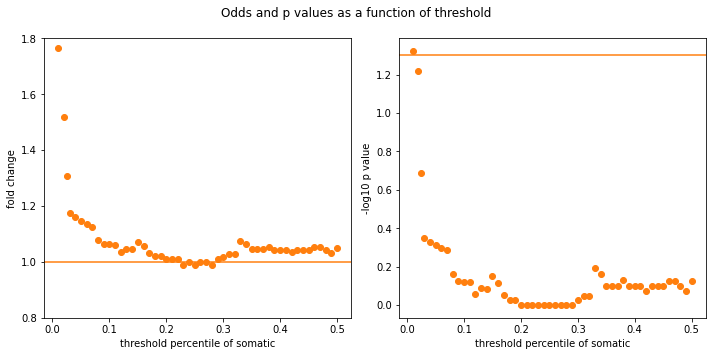

In [11]:
import matplotlib
plt.rcParams["figure.figsize"]=20,10
matplotlib.rcParams['pdf.fonttype']=42
fisher, odds, pvals = get_enrichments(somatic_df_dict, pancan_matched_dict, nonpancan_matched_dict, ism_thresh)
plot_percentiles(odds, pvals, 0.8,1.8,"Odds and p values as a function of threshold","./varied_thresholds_with_ism.pdf")

### near og.tsg - without ism

0.5
[[3488. 3624.]
 [3553. 3559.]]
0.9640977465798576 0.28313653898540697
0.49
[[3423. 3689.]
 [3496. 3616.]]
0.9597436376189215 0.22710522288758397
0.48
[[3357. 3755.]
 [3417. 3695.]]
0.9667426165171635 0.32192129741634595
0.47
[[3290. 3822.]
 [3355. 3757.]]
0.9639486196863246 0.2821205810709004
0.46
[[3232. 3880.]
 [3300. 3812.]]
0.9622293033427054 0.25961111175562995
0.45
[[3161. 3951.]
 [3225. 3887.]]
0.9642780652135953 0.2882244111988845
0.44
[[3093. 4019.]
 [3153. 3959.]]
0.9663255104381685 0.3188539879438074
0.43
[[3017. 4095.]
 [3087. 4025.]]
0.9606178653797701 0.24244573043817422
0.42
[[2949. 4163.]
 [3026. 4086.]]
0.9565282484938366 0.19667225099578972
0.41
[[2886. 4226.]
 [2943. 4169.]]
0.9674053104585805 0.33970236210453303
0.4
[[2834. 4278.]
 [2875. 4237.]]
0.9762918877167307 0.4938350841701354
0.39
[[2763. 4349.]
 [2804. 4308.]]
0.9760884247415823 0.4919648972339135
0.38
[[2686. 4426.]
 [2722. 4390.]]
0.9787482490247827 0.5454867812717873
0.37
[[2616. 4496.]
 [2642. 4470.

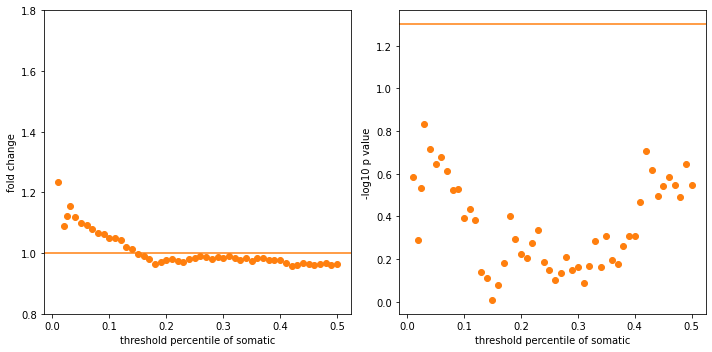

In [12]:
fisher, odds, pvals = get_enrichments(somatic_df_dict, pancan_matched_dict, nonpancan_matched_dict, ism_thresh = None)
plot_percentiles(odds, pvals,0.8,1.8)

### near og - with ism

In [13]:
# cosmos_pancan_file = "/illumina/scratch/deep_learning/asalcedo/cancer_gene_census.csv"
# cosmos_pancan_df = pd.read_csv(cosmos_pancan_file)
# cosmos_pancan_df = cosmos_pancan_df[(~cosmos_pancan_df["Role in Cancer"].isna()) & 
#                                         (cosmos_pancan_df["Role in Cancer"]!="fusion")]

# oncogenes = cosmos_pancan_df[(~cosmos_pancan_df["Role in Cancer"].isin(['TSG, fusion','TSG']))]["Gene Symbol"].tolist()
# oncogenes = list(set(oncogenes))
# len(oncogenes)

In [14]:
# def get_enrichments_og(somatic_df_dict, pancan_matched_dict, nonpancan_matched_dict, ism_thresh):
#     q_to_or = {}
#     q_to_pval = {}
#     q_to_fisher = {}
    
#     all_tcga_cancers = list(somatic_df_dict.keys())

#     for q in [round(x,2) for x in np.linspace(0.5, 0.01, 50)] + [0.025]:
#         print(q)

#         total_fisher = np.zeros((2,2))

#         for cancer_name in all_tcga_cancers:

#             if cancer_name in ["SKCM","COAD"]:
#                 continue

#             somatic_df = somatic_df_dict[cancer_name].copy()


#             threshold = somatic_df["diff_mutation_centered"].quantile(q)
#             ism_es = None
#             if ism_thresh:
#                 ism_es = ism_thresh[cancer_name.lower()]

#             pancan_df = pancan_matched_dict[cancer_name].copy().reset_index(drop=True)
#             nonpancan_df = nonpancan_matched_dict[cancer_name].copy().reset_index(drop=True)
            
#             pancan_df["closest_og"] = pancan_df["gene"].apply(lambda x : ingene_indicator(x, oncogenes))
#             pancan_df = pancan_df[pancan_df["closest_og"]==1]
#             nonpancan_df = nonpancan_df[nonpancan_df.index.isin(pancan_df.index)]
        
            
#             if q == 0.5:
#                 print(pancan_df.shape)
#                 print(nonpancan_df.shape)
#                 print(scipy.stats.ranksums(pancan_df["diff_mutation_centered"], nonpancan_df["diff_mutation_centered"]))

#                 assert (pancan_df["gc_2m"]==nonpancan_df["gc_2m"]).all()
            
#             l1 = None
#             if ism_thresh:
#                 l1 = pancan_df[(pancan_df["diff_mutation_centered"]<threshold) & (pancan_df["mut"] > ism_es) & (pancan_df["ref-mut"] < 0)]
#             else:
#                 l1 = pancan_df[(pancan_df["diff_mutation_centered"]<threshold)]
                
#             l2 = pancan_df[~pancan_df.index.isin(l1.index)]
            
#             l3 = None
#             if ism_thresh:
#                 l3 = nonpancan_df[(nonpancan_df["diff_mutation_centered"]<threshold) & (nonpancan_df["mut"] > ism_es) & (nonpancan_df["ref-mut"] < 0)]
#             else:
#                 l3 = nonpancan_df[(nonpancan_df["diff_mutation_centered"]<threshold)]
                
#             l4 = nonpancan_df[~nonpancan_df.index.isin(l3.index)]

#             fisher_matrix = np.array([[len(l1),len(l2)],[len(l3),len(l4)]])

#             assert fisher_matrix.sum() == len(pancan_df) + len(nonpancan_df)
#             total_fisher += fisher_matrix
#             fold_change,pval = scipy.stats.fisher_exact(fisher_matrix)

#         print(total_fisher)
#         fold_change,pval = scipy.stats.fisher_exact(total_fisher)
#         print(fold_change, pval)
#         q_to_or[q] = fold_change
#         q_to_pval[q] = -np.log10(pval)
#         q_to_fisher[q] = total_fisher

#     return q_to_fisher, q_to_or, q_to_pval

# def plot_percentiles(q_to_or, q_to_pval, ymin=None, ymax=None):
    
        
#     fig,axes = plt.subplots(1,2,figsize=(10,5))
#     ax1,ax2 = axes
#     ax1.scatter(q_to_or.keys(),q_to_or.values(), color="#ff7f0e")
#     ax1.set_xlabel("threshold percentile of somatic")
#     ax1.set_ylabel("fold change")
#     ax1.axhline(1.0,color="#ff7f0e")
#     ax1.set_ylim(bottom=ymin,top=ymax)
        
    
#     ax2.scatter(q_to_pval.keys(),q_to_pval.values(), color="#ff7f0e")
#     ax2.set_xlabel("threshold percentile of somatic")
#     ax2.set_ylabel("-log10 p value")
#     ax2.axhline(-np.log10(0.05),color="#ff7f0e")

#     fig.suptitle("Odds and -log10 p values as the threshold is increased")
#     fig.tight_layout()
#     plt.show()

In [15]:
# pancan_matched_dict = read_pickle("pancan_matched_dict_ogtsg.pkl")
# nonpancan_matched_dict = read_pickle("nonpancan_matched_dict_ogtsg.pkl")
# fisher, odds, pvals = get_enrichments_og(somatic_df_dict, pancan_matched_dict, nonpancan_matched_dict, ism_thresh)
# plot_percentiles(odds, pvals)

### pli matched genes - median of 5

In [16]:
### for each random pli geneset - compute odds and p vals as a function of quantile and 
### create a dataframe with 5 columns (one for each genelist)
df_or = pd.DataFrame()
df_or.index = [round(x,2) for x in np.linspace(0.5, 0.01, 50)] + [0.025]

df_pval = pd.DataFrame()
df_pval.index = [round(x,2) for x in np.linspace(0.5, 0.01, 50)] + [0.025]
for i in range(5):
    
    pancan_matched_dict = read_pickle(f"pancan_matched_dict_pli_x2{i}.pkl")
    nonpancan_matched_dict = read_pickle(f"nonpancan_matched_dict_pli_x2{i}.pkl")
    
    fisher, odds, pvals = get_enrichments(somatic_df_dict, pancan_matched_dict, nonpancan_matched_dict, ism_thresh)

    df_or[f"odds_{i}"] = df_or.index.map(odds.get)
    df_pval[f"odds_{i}"] = df_pval.index.map(pvals.get)

0.5
[[ 124. 7811.]
 [ 126. 7809.]]
0.983874999237949 0.9491859742962284
0.49
[[ 123. 7812.]
 [ 124. 7811.]]
0.9918085080025767 1.0
0.48
[[ 122. 7813.]
 [ 124. 7811.]]
0.9836191128929039 0.9487819082840196
0.47
[[ 122. 7813.]
 [ 123. 7812.]]
0.9917429674744719 1.0
0.46
[[ 122. 7813.]
 [ 123. 7812.]]
0.9917429674744719 1.0
0.45
[[ 120. 7815.]
 [ 123. 7812.]]
0.9752352417957961 0.8971588729399703
0.44
[[ 118. 7817.]
 [ 123. 7812.]]
0.9587359632071439 0.7952032692014488
0.43
[[ 118. 7817.]
 [ 122. 7813.]]
0.9667181867178931 0.8453407817627722
0.42
[[ 117. 7818.]
 [ 120. 7815.]]
0.9746258633921719 0.8958932965835243
0.41
[[ 116. 7819.]
 [ 120. 7815.]]
0.9661721447755467 0.8440728393672043
0.4
[[ 116. 7819.]
 [ 120. 7815.]]
0.9661721447755467 0.8440728393672043
0.39
[[ 116. 7819.]
 [ 119. 7816.]]
0.9744159078134387 0.8954607140278488
0.38
[[ 116. 7819.]
 [ 119. 7816.]]
0.9744159078134387 0.8954607140278488
0.37
[[ 116. 7819.]
 [ 119. 7816.]]
0.9744159078134387 0.8954607140278488
0.36
[[ 116.

[[ 145. 8442.]
 [ 148. 8439.]]
0.9793815670681343 0.9062112459195184
0.36
[[ 145. 8442.]
 [ 148. 8439.]]
0.9793815670681343 0.9062112459195184
0.35
[[ 144. 8443.]
 [ 148. 8439.]]
0.9725120121898518 0.8594879898093125
0.34
[[ 144. 8443.]
 [ 147. 8440.]]
0.9792437643066229 0.9058967216308778
0.33
[[ 144. 8443.]
 [ 146. 8441.]]
0.9860677322058153 0.9527866713337053
0.32
[[ 141. 8446.]
 [ 146. 8441.]]
0.9651817022891601 0.8118445736453819
0.31
[[ 141. 8446.]
 [ 145. 8442.]]
0.9719532608784407 0.8580629785102486
0.3
[[ 140. 8447.]
 [ 144. 8443.]]
0.9717618352340739 0.8575780179738299
0.29
[[ 140. 8447.]
 [ 143. 8444.]]
0.978673274162797 0.9046054258100239
0.28
[[ 139. 8448.]
 [ 142. 8445.]]
0.9785256282010243 0.9042740091159303
0.27
[[ 139. 8448.]
 [ 141. 8446.]]
0.9855822184612079 0.9519666736133331
0.26
[[ 137. 8450.]
 [ 140. 8447.]]
0.9782240067624683 0.9036004335775755
0.25
[[ 136. 8451.]
 [ 139. 8448.]]
0.978069940213963 0.903258145411238
0.24
[[ 135. 8452.]
 [ 138. 8449.]]
0.977913640

1.0269568971180285 0.8941014633895187
0.25
[[ 115. 7545.]
 [ 112. 7548.]]
1.0271939789832434 0.8936460709382026
0.24
[[ 114. 7546.]
 [ 110. 7550.]]
1.0369129942413802 0.8400283956661947
0.23
[[ 114. 7546.]
 [ 109. 7551.]]
1.0465645569558695 0.7873607283074064
0.22
[[ 113. 7547.]
 [ 108. 7552.]]
1.0469894831892976 0.7864383545638562
0.21
[[ 110. 7550.]
 [ 106. 7554.]]
1.0382856428839184 0.8371782301650249
0.2
[[ 106. 7554.]
 [ 106. 7554.]]
1.0 1.0
0.19
[[ 106. 7554.]
 [ 106. 7554.]]
1.0 1.0
0.18
[[ 102. 7558.]
 [ 103. 7557.]]
0.990160236565383 1.0
0.17
[[ 102. 7558.]
 [ 101. 7559.]]
1.0100346102353024 1.0
0.16
[[  99. 7561.]
 [  97. 7563.]]
1.0208885258999996 0.942713269372967
0.15
[[  99. 7561.]
 [  97. 7563.]]
1.0208885258999996 0.942713269372967
0.14
[[  98. 7562.]
 [  96. 7564.]]
1.0211033236357225 0.9424232979912873
0.13
[[  97. 7563.]
 [  95. 7565.]]
1.0213226441748957 0.9421287987996582
0.12
[[  96. 7564.]
 [  92. 7568.]]
1.0440300738049801 0.8258235437639279
0.11
[[  95. 7565.]


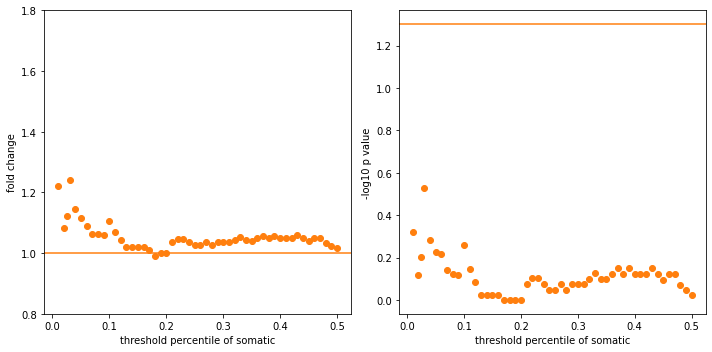

In [17]:
### compute median for each quantile and take the corresponding geneset's p value at that quantile
odds_median = {}
pvals_median = {}
df_or_np = df_or.to_numpy()
df_pval_np = df_pval.to_numpy()
for i in range(len(df_or_np)):
    
    ors_q = df_or_np[i]
    pvals_q = df_pval_np[i]
    q = df_or.index[i]
    
    median_q = sorted(ors_q)[2]
    
    pval_median_q_index = np.where(ors_q == median_q)[0]
    pval_median_q = pvals_q[pval_median_q_index[0]]
    
    odds_median[q] = median_q
    pvals_median[q] = pval_median_q
    
plot_percentiles(odds_median, pvals_median, 0.8, 1.8)

In [18]:
odds_median[0.025],10**-pvals_median[0.025], odds_median[0.01],10**-pvals_median[0.01]

(1.1208529001142278, 0.626272860685831, 1.2197872340425533, 0.4757351499069175)

### pli near og

In [19]:
# ### for each random pli geneset - compute odds and p vals as a function of quantile and 
# ### create a dataframe with 5 columns (one for each genelist)
# df_or = pd.DataFrame()
# df_or.index = [round(x,2) for x in np.linspace(0.5, 0.01, 50)] + [0.025]

# df_pval = pd.DataFrame()
# df_pval.index = [round(x,2) for x in np.linspace(0.5, 0.01, 50)] + [0.025]
# for i in range(5):
    
#     pancan_matched_dict = read_pickle(f"pancan_matched_dict_pli_onco_x2{i}.pkl")
#     nonpancan_matched_dict = read_pickle(f"nonpancan_matched_dict_pli_onco_x2{i}.pkl")
    
#     fisher, odds, pvals = get_enrichments(somatic_df_dict, pancan_matched_dict, nonpancan_matched_dict, ism_thresh)

#     df_or[f"odds_{i}"] = df_or.index.map(odds.get)
#     df_pval[f"odds_{i}"] = df_pval.index.map(pvals.get)

In [20]:
# ### compute median for each quantile and take the corresponding geneset's p value at that quantile
# odds_median = {}
# pvals_median = {}
# df_or_np = df_or.to_numpy()
# df_pval_np = df_pval.to_numpy()
# for i in range(len(df_or_np)):
    
#     ors_q = df_or_np[i]
#     pvals_q = df_pval_np[i]
#     q = df_or.index[i]
    
#     median_q = sorted(ors_q)[2]
    
#     pval_median_q_index = np.where(ors_q == median_q)[0]
#     pval_median_q = pvals_q[pval_median_q_index[0]]
    
#     odds_median[q] = median_q
#     pvals_median[q] = pval_median_q
    
# plot_percentiles(odds_median, pvals_median, 0.8,2.75)

### random genes - median of 5

In [21]:
### for each random pli geneset - compute odds and p vals as a function of quantile and 
### create a dataframe with 5 columns (one for each genelist)
df_or = pd.DataFrame()
df_or.index = [round(x,2) for x in np.linspace(0.5, 0.01, 50)] + [0.025]

df_pval = pd.DataFrame()
df_pval.index = [round(x,2) for x in np.linspace(0.5, 0.01, 50)] + [0.025]
for i in range(5):
    
    pancan_matched_dict = read_pickle(f"pancan_matched_dict_random_{i}.pkl")
    nonpancan_matched_dict = read_pickle(f"nonpancan_matched_dict_random_{i}.pkl")
    
    fisher, odds, pvals = get_enrichments(somatic_df_dict, pancan_matched_dict, nonpancan_matched_dict, ism_thresh)

    df_or[f"odds_{i}"] = df_or.index.map(odds.get)
    df_pval[f"odds_{i}"] = df_pval.index.map(pvals.get)

0.5
[[ 110. 6841.]
 [ 107. 6844.]]
1.0284882108562037 0.8911962111516113
0.49
[[ 110. 6841.]
 [ 106. 6845.]]
1.0383426234165258 0.8370608411302588
0.48
[[ 109. 6842.]
 [ 104. 6847.]]
1.0488428372270815 0.7824696871109955
0.47
[[ 108. 6843.]
 [ 104. 6847.]]
1.0390685596735574 0.8355773912934247
0.46
[[ 108. 6843.]
 [ 104. 6847.]]
1.0390685596735574 0.8355773912934247
0.45
[[ 108. 6843.]
 [ 104. 6847.]]
1.0390685596735574 0.8355773912934247
0.44
[[ 107. 6844.]
 [ 104. 6847.]]
1.029297138425572 0.8896950337869209
0.43
[[ 107. 6844.]
 [ 103. 6848.]]
1.0394421022169513 0.834819970475907
0.42
[[ 107. 6844.]
 [ 101. 6850.]]
1.0603347009160295 0.7269463309041454
0.41
[[ 106. 6845.]
 [ 100. 6851.]]
1.060929145361578 0.7256972949064854
0.4
[[ 105. 6846.]
 [ 100. 6851.]]
1.0507668711656442 0.7784404732214281
0.39
[[ 105. 6846.]
 [ 100. 6851.]]
1.0507668711656442 0.7784404732214281
0.38
[[ 104. 6847.]
 [ 100. 6851.]]
1.0406075653570908 0.8324819070022015
0.37
[[ 104. 6847.]
 [ 100. 6851.]]
1.04060

1.174535587901176 0.2419512240720026
0.35
[[ 129. 6615.]
 [ 111. 6633.]]
1.165324508181651 0.2681545970364131
0.34
[[ 129. 6615.]
 [ 110. 6634.]]
1.1760956503813647 0.24002419175901624
0.33
[[ 128. 6616.]
 [ 107. 6637.]]
1.2000587643661924 0.18800603501680027
0.32
[[ 127. 6617.]
 [ 105. 6639.]]
1.2135451974351779 0.1641709954666632
0.31
[[ 126. 6618.]
 [ 105. 6639.]]
1.2038077969174978 0.18428736603538776
0.3
[[ 126. 6618.]
 [ 104. 6640.]]
1.2155659390473534 0.16237694212464696
0.29
[[ 125. 6619.]
 [ 102. 6642.]]
1.2297485847337877 0.14068473371879006
0.28
[[ 124. 6620.]
 [ 101. 6643.]]
1.2319882743561366 0.13895777079222507
0.27
[[ 123. 6621.]
 [ 101. 6643.]]
1.221868312794125 0.15694285690923218
0.26
[[ 122. 6622.]
 [  99. 6645.]]
1.2366034247641013 0.13548373948628128
0.25
[[ 122. 6622.]
 [  98. 6646.]]
1.2494098213130012 0.11774931253557215
0.24
[[ 121. 6623.]
 [  97. 6647.]]
1.2519430102221094 0.11610083026154297
0.23
[[ 120. 6624.]
 [  97. 6647.]]
1.2414089347079038 0.13198335992

[[ 128. 7171.]
 [ 113. 7186.]]
1.1351127883572354 0.36319050628086463
0.25
[[ 128. 7171.]
 [ 113. 7186.]]
1.1351127883572354 0.36319050628086463
0.24
[[ 126. 7173.]
 [ 113. 7186.]]
1.1170651003208936 0.4338944713717722
0.23
[[ 124. 7175.]
 [ 112. 7187.]]
1.108994524639124 0.4704307291709696
0.22
[[ 123. 7176.]
 [ 112. 7187.]]
1.0998977245580506 0.5108508599645825
0.21
[[ 122. 7177.]
 [ 109. 7190.]]
1.1212934284213203 0.42617134589026084
0.2
[[ 120. 7179.]
 [ 108. 7191.]]
1.112968379997214 0.462870858569346
0.19
[[ 119. 7180.]
 [ 108. 7191.]]
1.1035399257195915 0.5036156008312002
0.18
[[ 118. 7181.]
 [ 107. 7192.]]
1.104493035229259 0.5017552250720634
0.17
[[ 114. 7185.]
 [ 107. 7192.]]
1.066458548767877 0.6843247475309259
0.16
[[ 112. 7187.]
 [ 104. 7195.]]
1.0781218225214328 0.6314311747679164
0.15
[[ 110. 7189.]
 [ 102. 7197.]]
1.0796314631013066 0.6282804186424018
0.14
[[ 102. 7197.]
 [ 101. 7198.]]
1.0100413125931185 1.0
0.13
[[ 100. 7199.]
 [ 100. 7199.]]
1.0 1.0
0.12
[[  99. 7200

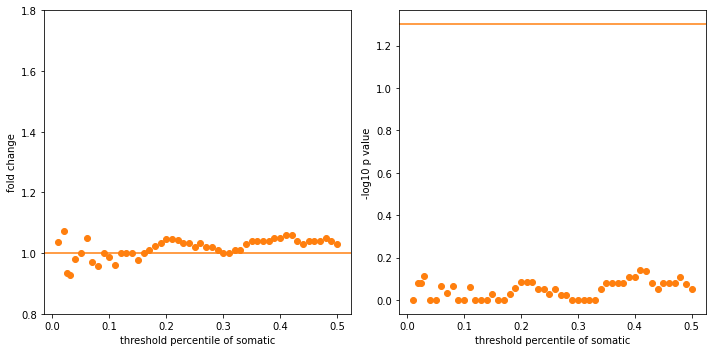

In [22]:
### compute median for each quantile and take the corresponding geneset's p value at that quantile
odds_median = {}
pvals_median = {}
df_or_np = df_or.to_numpy()
df_pval_np = df_pval.to_numpy()
for i in range(len(df_or_np)):
    
    ors_q = df_or_np[i]
    pvals_q = df_pval_np[i]
    q = df_or.index[i]
    
    median_q = sorted(ors_q)[2]
    
    pval_median_q_index = np.where(ors_q == median_q)[0]
    pval_median_q = pvals_q[pval_median_q_index[0]]
    
    odds_median[q] = median_q
    pvals_median[q] = pval_median_q
    
plot_percentiles(odds_median, pvals_median, 0.8, 1.8)

In [23]:
odds_median[0.025],10**-pvals_median[0.025], odds_median[0.01],10**-pvals_median[0.01]

(0.9357635947496988, 0.8335413665230681, 1.0358639121641144, 1.0)

### supplementary plots

In [4]:
somatic_df_dict = read_pickle("somatic_df_dict_gof.pkl")
pancan_matched_dict = read_pickle("pancan_matched_dict_ogtsg.pkl")
nonpancan_matched_dict = read_pickle("nonpancan_matched_dict_ogtsg.pkl")

In [6]:
import matplotlib
plt.rcParams["figure.figsize"]=20,10
matplotlib.rcParams['pdf.fonttype']=42

### matching

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


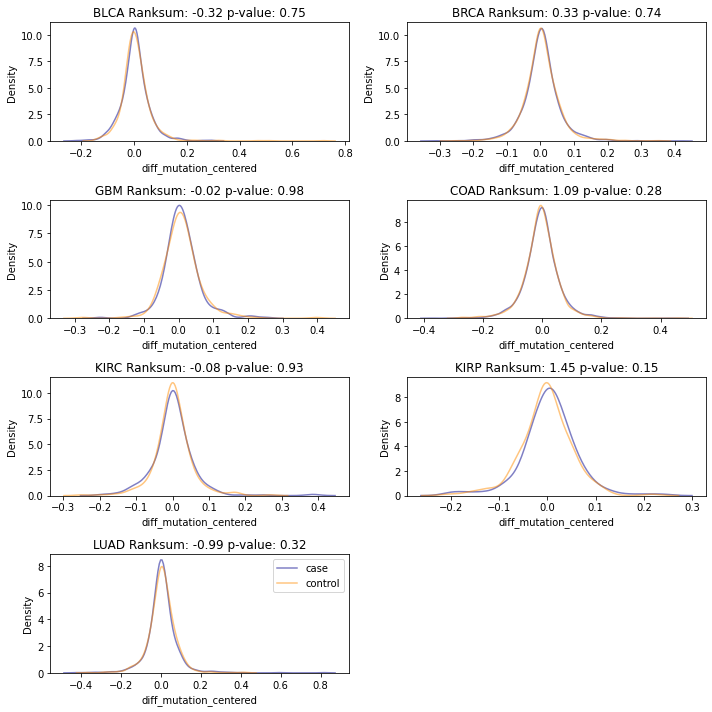

,case,control,case mean,control mean,ranksums,pvalue
BLCA,694.0,694.0,0.003359,0.007648,-0.319960,0.748998
BRCA,2087.0,2087.0,0.003486,0.003893,0.326643,0.743938
GBM,296.0,296.0,0.008783,0.009344,-0.019704,0.984279
COAD,2584.0,2584.0,-0.002511,-0.004633,1.086320,0.277337
KIRC,357.0,357.0,0.001446,0.001632,-0.084371,0.932762
KIRP,198.0,198.0,0.004457,-0.002404,1.450575,0.146898
LUAD,896.0,896.0,0.005931,0.006472,-0.993302,0.320563


In [26]:
df=create_pancancer_distribution_plots(pancan_matched_dict, nonpancan_matched_dict,"diff_mutation_centered",False)
df

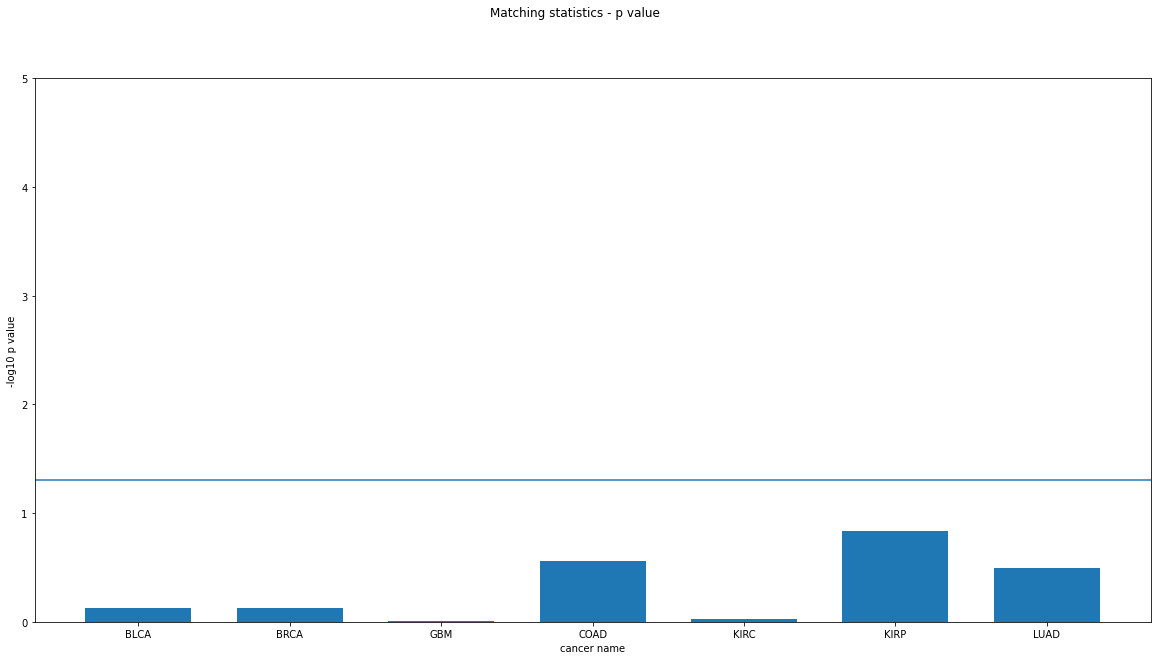

In [27]:
fig,ax2 = plt.subplots(figsize=(20,10))
ax2.bar(np.arange(7),
        -np.log10(df["pvalue"]),
        0.7,
        label=df.index,
        color='#1f77b4')
ax2.set_xticks(np.arange(len(df.index)), df.index)
ax2.set_xlabel("cancer name")
ax2.set_ylabel("-log10 p value")
ax2.axhline(-np.log10(0.05),color="#1f77b4")
ax2.set_ylim(0,5)

fig.suptitle("Matching statistics - p value")

fig.savefig("./matching_bar_plot_outside_peaks.pdf",dpi=1200)

### table

In [7]:
all_mutations = []
df_ism_thresh = []
for cancer_name in all_tcga_cancers:
    
    
    somatic_df = somatic_df_dict[cancer_name].copy()
    threshold = somatic_df["diff_mutation_centered"].quantile(0.025)
    ism_es = ism_thresh[cancer_name.lower()]

    print(cancer_name, threshold, ism_es)
    df_ism_thresh.append((cancer_name, threshold, ism_es))
    
    pancan_df = pancan_matched_dict[cancer_name][["Chromosome","hg38_start","Reference_Allele","Tumor_Seq_Allele2","sample","diff_mutation_centered","proba_ref_mutation_centered","proba_alt_mutation_centered","ref","mut","ref-mut","closest_pancan"]].copy()
    pancan_df["sample"] = pancan_df["sample"].apply(lambda x : x.upper())
    pancan_df["prioritized"] = 0
    indices = pancan_df[(pancan_df["diff_mutation_centered"]<threshold) & (pancan_df["mut"] > ism_es) & (pancan_df["ref-mut"] < 0)].index
    pancan_df.loc[indices,"prioritized"] = 1

    
    nonpancan_df = nonpancan_matched_dict[cancer_name][["Chromosome","hg38_start","Reference_Allele","Tumor_Seq_Allele2","sample","diff_mutation_centered","proba_ref_mutation_centered","proba_alt_mutation_centered","ref","mut","ref-mut","closest_pancan"]].copy()
    nonpancan_df["sample"] = nonpancan_df["sample"].apply(lambda x : x.upper())
    nonpancan_df["prioritized"] = 0
    indices = nonpancan_df[(nonpancan_df["diff_mutation_centered"]<threshold) & (nonpancan_df["mut"] > ism_es) & (nonpancan_df["ref-mut"] < 0)].index
    nonpancan_df.loc[indices,"prioritized"] = 1
    
    all_mutations.append(pancan_df)
    all_mutations.append(nonpancan_df)
    
all_mutations = pd.concat(all_mutations, axis=0, ignore_index=True)
all_mutations.shape

BLCA -0.1013707178831101 0.393249265576302
BRCA -0.10565867498517036 0.34552914537146884
GBM -0.09311624765396118 0.3969854090822131
COAD -0.1298457471840084 0.3665412973954391
KIRC -0.10346610184758903 0.44200819215624415
KIRP -0.11504888236522674 0.4390704091109736
LUAD -0.13411077000200744 0.527243441255984


(14224, 13)

In [11]:
df_ism_thresh = pd.DataFrame(df_ism_thresh,columns=["Cancer Type","Mutation score threshold","ISM threhsold"])
df_ism_thresh["Cancer Type"] = df_ism_thresh["Cancer Type"].apply(lambda x : x.upper())
df_ism_thresh.to_excel("./gof_thresholds.xlsx")
df_ism_thresh

,Cancer Type,Mutation score threshold,ISM threhsold
0,BLCA,-0.101371,0.393249
1,BRCA,-0.105659,0.345529
2,GBM,-0.093116,0.396985
3,COAD,-0.129846,0.366541
4,KIRC,-0.103466,0.442008
5,KIRP,-0.115049,0.439070
6,LUAD,-0.134111,0.527243


In [8]:
all_mutations.columns = ["chr","pos","ref","alt","sample","effect_size","ref_proba","alt_proba","ref_ism","alt_ism","ism_diff","og/tsg","prioritized"]
all_mutations = all_mutations.sort_values(["chr","pos","sample"]).reset_index(drop=True)
all_mutations

,chr,pos,ref,alt,sample,effect_size,ref_proba,alt_proba,ref_ism,alt_ism,ism_diff,og/tsg,prioritized
0,chr1,971850,C,A,BRCA,-0.033924,0.478723,0.512646,0.053278,0.105845,-0.052567,0,0
1,chr1,1354519,C,A,LUAD,-0.021322,0.556181,0.577504,-0.001972,0.003746,-0.005718,0,0
2,chr1,2236916,C,G,LUAD,-0.011741,0.503042,0.514783,-0.013858,-0.118570,0.104712,1,0
3,chr1,2237302,G,A,GBM,0.061194,0.357885,0.296691,0.032613,-0.090567,0.123180,1,0
4,chr1,2238498,G,T,BRCA,0.018657,0.725544,0.706887,-0.097531,-0.052462,-0.045069,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14219,chr9,137577836,G,A,KIRP,0.019275,0.707259,0.687985,-0.086649,-0.030228,-0.056421,0,0
14220,chr9,137587931,C,T,GBM,0.182348,0.560630,0.378281,0.572012,-0.184870,0.756882,0,0
14221,chr9,137695020,C,T,GBM,0.074483,0.375456,0.300973,0.080235,-0.488983,0.569218,0,0
14222,chr9,137712141,G,T,BRCA,-0.052016,0.444094,0.496110,-0.072551,0.093427,-0.165978,0,0


In [9]:
### sanity check - please check if the values are correct
l1 = all_mutations[(all_mutations["prioritized"]==1) & (all_mutations["og/tsg"]==1)].shape[0]
l2 = all_mutations[(all_mutations["prioritized"]==0) & (all_mutations["og/tsg"]==1)].shape[0]
l3 = all_mutations[(all_mutations["prioritized"]==1) & (all_mutations["og/tsg"]==0)].shape[0]
l4 = all_mutations[(all_mutations["prioritized"]==0) & (all_mutations["og/tsg"]==0)].shape[0]

fisher_matrix = [[l1,l2],[l3,l4]]
scipy.stats.fisher_exact(fisher_matrix)

(1.3069372857530395, 0.2048016460993621)

In [31]:
all_mutations.to_excel("./all_mutations_outside_peaks.xlsx")

### correlations

In [32]:
### compute phylop
for cancer_name in all_tcga_cancers:
    somatic_df = somatic_df_dict[cancer_name].copy()
    print(somatic_df.shape)
    somatic_df = annotatePhylopScore(somatic_df,"phylop_mutation")
    print(somatic_df.shape)
    somatic_df_dict[cancer_name] = somatic_df

(11393, 59)


100%|██████████| 11393/11393 [00:02<00:00, 5613.62it/s]


(11393, 60)
(33464, 59)


100%|██████████| 33464/33464 [00:05<00:00, 6061.26it/s]


(33464, 60)
(4989, 59)


100%|██████████| 4989/4989 [00:00<00:00, 5197.18it/s]


(4989, 60)
(43990, 59)


100%|██████████| 43990/43990 [00:07<00:00, 6181.13it/s]


(43990, 60)
(5492, 59)


100%|██████████| 5492/5492 [00:01<00:00, 5486.18it/s]


(5492, 60)
(3183, 59)


100%|██████████| 3183/3183 [00:00<00:00, 5277.74it/s]


(3183, 60)
(15102, 59)


100%|██████████| 15102/15102 [00:02<00:00, 5860.56it/s]

(15102, 60)


BLCA
BRCA
GBM
COAD
KIRC
KIRP
LUAD


,BLCA,BRCA,GBM,COAD,KIRC,KIRP,LUAD
0,-0.060285,-0.014103,0.003622,0.012346,-0.019662,-0.000649,-0.058224
1,-0.023886,-0.027575,-0.046924,-0.008576,0.018936,-0.007044,-0.040679
2,-0.024700,-0.024287,-0.057297,-0.005252,0.005140,-0.010251,-0.036484
3,-0.037887,-0.024249,-0.047003,0.017238,0.001141,0.013172,-0.047637
4,-0.051420,-0.017700,-0.012701,0.015751,0.015887,0.022869,-0.077088


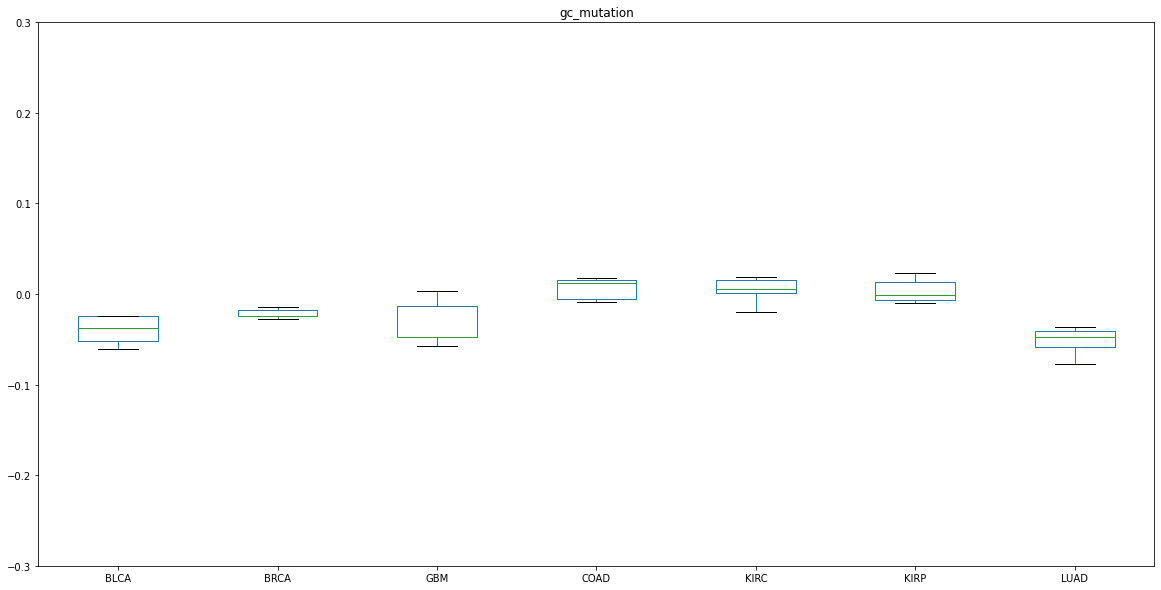

BLCA
BRCA
GBM
COAD
KIRC
KIRP
LUAD


,BLCA,BRCA,GBM,COAD,KIRC,KIRP,LUAD
0,-0.006313,-0.018253,0.001605,-0.055232,-0.005191,-0.048375,-0.017168
1,-0.017057,-0.019369,-0.029543,-0.059556,-0.002060,-0.041314,-0.001602
2,-0.019457,-0.029345,-0.023059,-0.046487,-0.007985,-0.044976,-0.009121
3,-0.013109,-0.022684,-0.037532,-0.039088,0.003525,-0.013249,-0.009600
4,-0.017511,-0.030738,-0.038793,-0.056728,0.000671,-0.038345,-0.008042


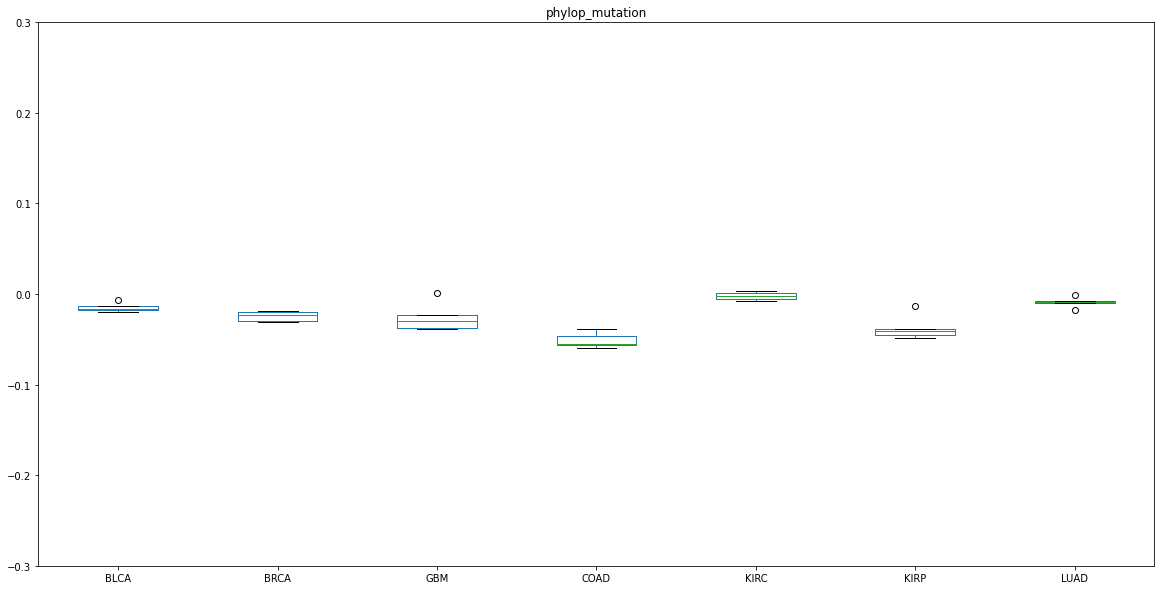

BLCA
BRCA
GBM
COAD
KIRC
KIRP
LUAD


,BLCA,BRCA,GBM,COAD,KIRC,KIRP,LUAD
0,0.039241,0.025747,0.023350,0.018316,0.017349,0.022417,0.032929
1,0.022968,0.032107,0.017881,0.022908,0.020714,0.037935,0.027580
2,0.019470,0.020387,0.023559,0.018321,0.024665,0.003804,0.033364
3,0.017908,0.018580,0.041524,0.005983,0.030505,0.027521,0.018741
4,0.025535,0.024945,0.009962,0.011872,-0.001841,0.006860,0.036547


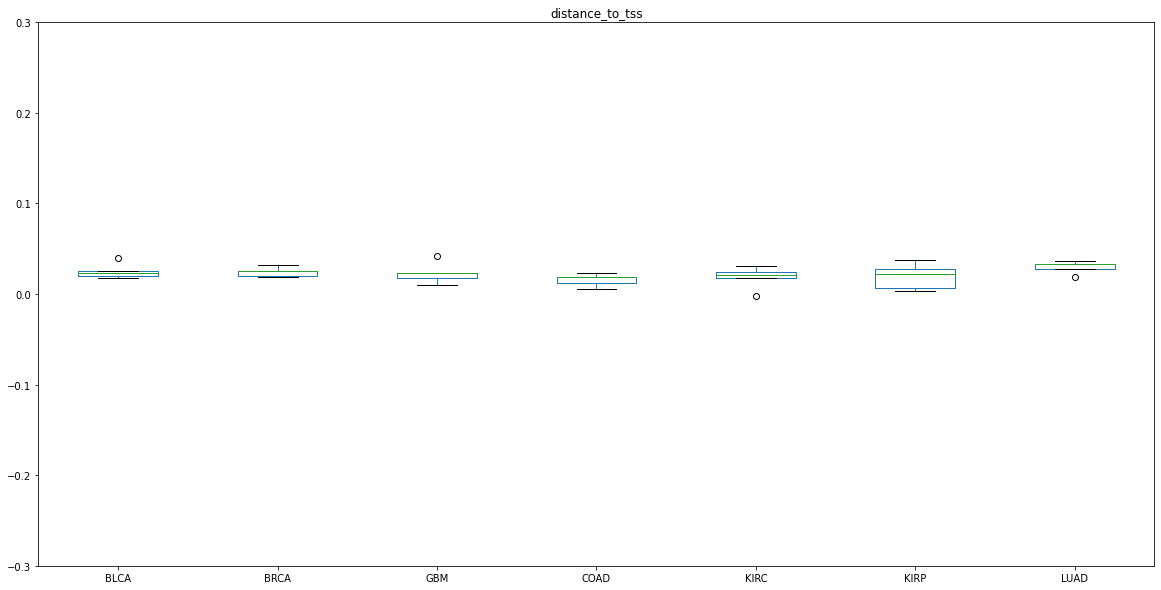

BLCA
BRCA
GBM
COAD
KIRC
KIRP
LUAD


,BLCA,BRCA,GBM,COAD,KIRC,KIRP,LUAD
0,0.012845,0.000014,-0.010467,0.002579,0.036263,0.001309,0.008578
1,-0.000069,0.001960,0.002118,0.010665,0.029325,-0.012730,0.005742
2,0.006088,0.011508,0.018265,0.012519,0.048576,-0.023379,0.010052
3,0.003052,0.006313,-0.003835,-0.004959,0.039754,-0.020462,0.005880
4,0.008673,0.010853,-0.005365,0.009554,0.003501,-0.019454,-0.004786


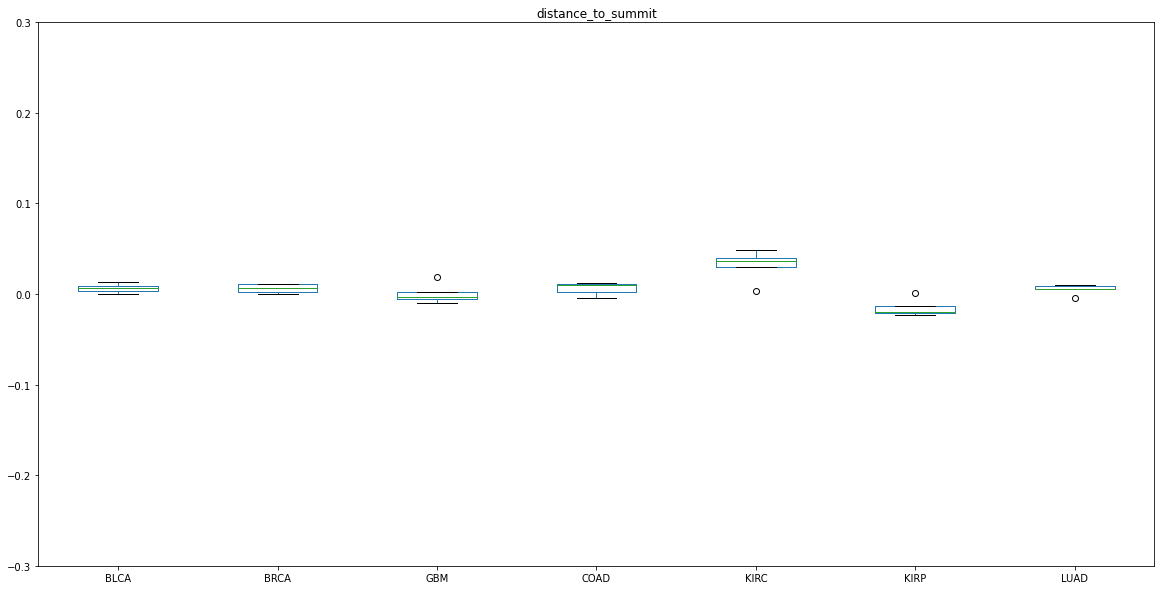

In [33]:
for quantity in ["gc_mutation","phylop_mutation","distance_to_tss","distance_to_summit"]:
    df_stats = pd.DataFrame()

    for cancer_name in all_tcga_cancers:

        print(cancer_name)

        somatic_df = somatic_df_dict[cancer_name].copy()


        for fold in range(5):
            spr, pval = scipy.stats.spearmanr(somatic_df[f"fold_{fold}_diff_mutation_centered"], 
                                              somatic_df[quantity])
            df_stats.loc[fold,cancer_name] = spr


    display(df_stats)

    fig,ax=plt.subplots()
    df_stats.boxplot(ax=ax)
    ax.set_title(quantity)
    ax.set_xticks(ax.get_xticks(),rotation=90)
    ax.grid(False)
    ax.set_ylim(-0.3,0.3)
    fig.savefig(f'{quantity}_effect_size.pdf',dpi=1200)
    plt.show()

In [34]:
print("Done")

Done
